# Polaris

In [2]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


INFO: Auto-setting vmin to -1.796e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.668e+01 [aplpy.core]


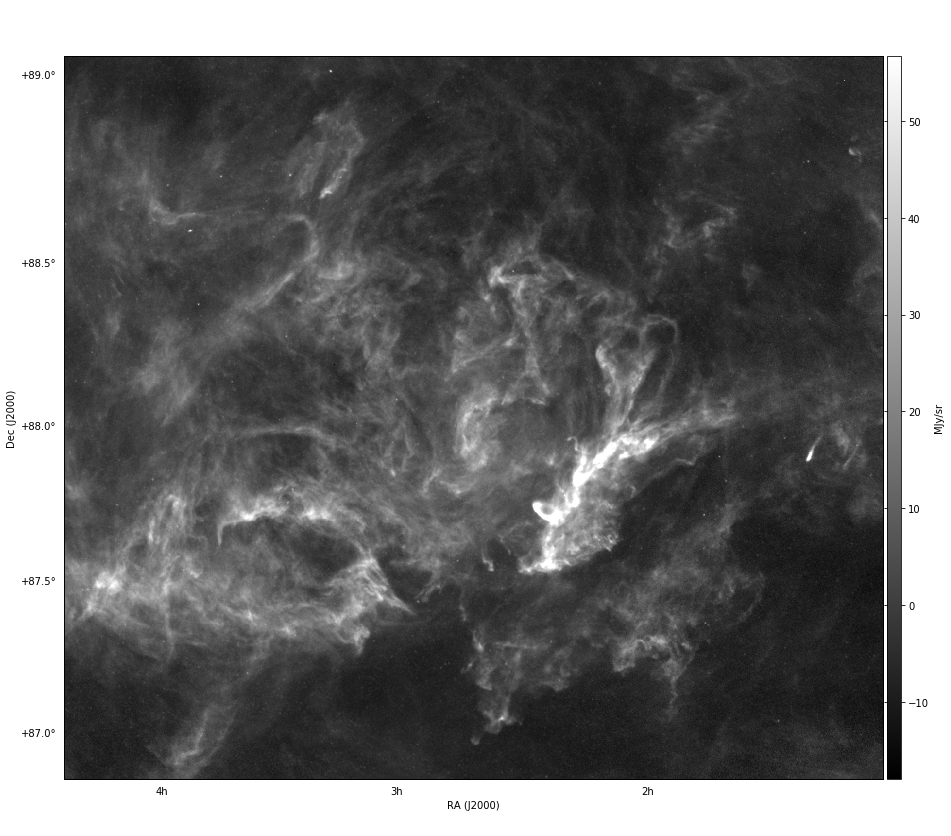

In [13]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/polaris-250_cut.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.25)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
#fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.colorbar.set_axis_label_text(r'MJy/sr')

In [14]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
output_notebook()

from astropy import wcs
from powspec import powspec
from wavan import fan_trans, apodize, padding, depad
from rebin import congrid
from gauss_beam import gauss_beam

Loading BokehJS ...

In [15]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [42]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,1800,1800)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 18.2 / (60.*reso)  #Beam size at 250 micron
beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
beam = gauss_beam(FWHM,1800,1800,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
#del Bwt,BS11a,Bq
#BS1an = BS1a / BS1a[4]

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log",x_range=(0.003, 4), \
           y_range=(1, 10**8), tools=Tools)
f.line(tab_k[0:391], spec_k[0:391]/spec_beamn[0:391], legend='Fourier')
#f.line(tab_k, spec_k, legend='Fourier')

#Set a list of q
q=[]
#q[0:4]=[1.4]*5
#q[5:25]=[2.5]*20
#q=[2.1]*27
print q

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True)
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=False, apodize= 0.98, arrdim = np.array([1800,1800]))

S1an = np.copy(S1a)

S1an[0,3:] = S1a[0,3:]/BS1an[3:]
S1an[1,3:] = S1a[1,3:]/BS1an[3:]
S1an[2,3:] = S1a[2,3:]/BS1an[3:]

f.diamond(wav_k[0:21], S1an[0,0:21], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k[0:21], S1an[1,0:21], legend='Coherent',color='blue',line_width=5)
f.square(wav_k[0:21], S1an[2,0:21], legend='Gaussian',color='red',line_width=5)

#Power law fit
coef = np.polyfit(np.log(wav_k[6:15]),np.log(S1an[2,6:15]),deg=1)
yfit = np.exp(coef[1])*wav_k**coef[0]

coef2 = np.polyfit(np.log(wav_k[12:17]),np.log(S1an[1,12:17]),deg=1)
yfit2 = np.exp(coef2[1])*wav_k**coef2[0]

print "Power law = ", coef[0],coef2[0]

f.line(wav_k, yfit, legend='Fit', line_dash='dashed')
f.line(wav_k, yfit2, line_dash='dashed')

showbok(f)

[]
Power law =  -3.216711628002255 -2.738828328268427


In [32]:
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_Bwav_k.npy',Bwav_k)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_BS1a.npy',BS1a)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_wt.npy',wt)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_S11a.npy',S11a)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_wav_k.npy',wav_k)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_S1a.npy',S1a)
np.save('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_q.npy',q)

INFO: Auto-setting vmin to -2.329e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.899e+01 [aplpy.core]
INFO: Auto-setting vmin to -2.815e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.208e+01 [aplpy.core]


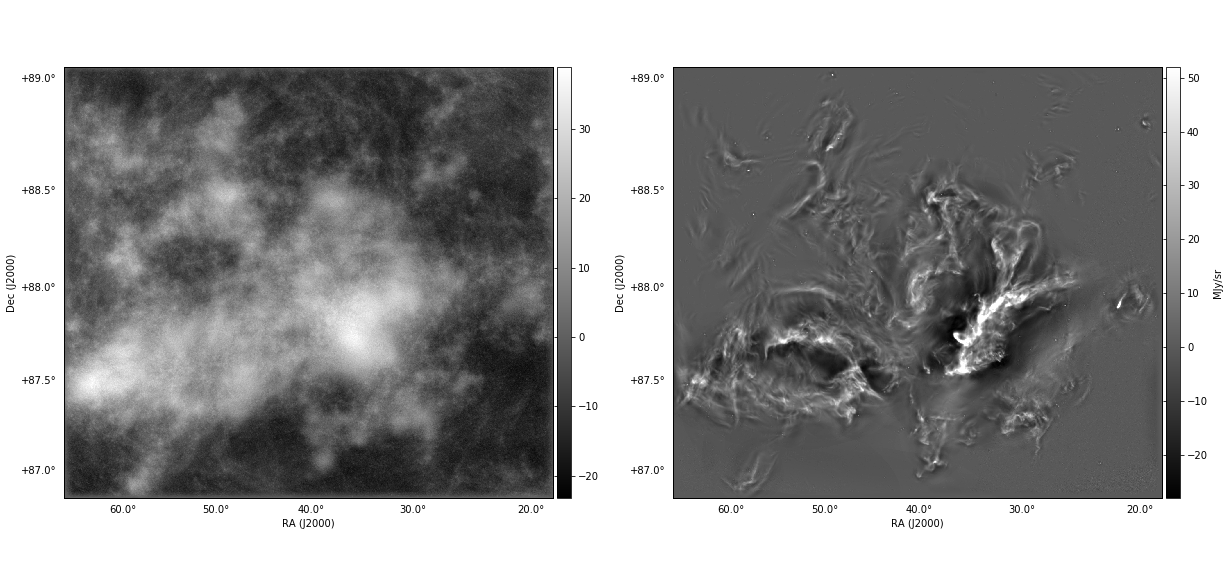

In [35]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_cohe.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_gaussian.fits',\
            Gaussian.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,10))

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/Gould Belt/analysis/Polaris_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
#fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.colorbar.set_axis_label_text(r'MJy/sr')

[2.5, 2.5, 2.5, 2.5, 2.5, 2.0999999999999996, 2.0999999999999996, 1.9999999999999996, 2.0999999999999996, 2.0999999999999996, 2.0999999999999996, 2.1999999999999997, 2.0999999999999996, 2.1999999999999997, 2.0999999999999996, 2.0999999999999996, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.3, 2.3, 2.4, 2.5, 2.5, 2.5, 2.5, 2.5]
wav_k.shape[0]= 26


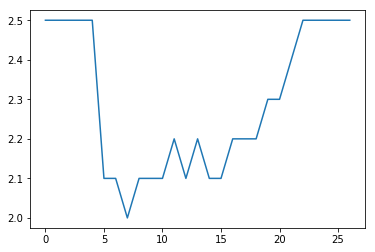

In [27]:
print q
print 'wav_k.shape[0]=',wav_k.shape[0]

x = range(27)
plot(x,np.array(q).reshape(27))

In [31]:
#Plot Beam power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_beamn, legend='Fourier')
f.diamond(Bwav_k, BS1an, legend='Wavelet',color='black',line_width=5)
showbok(f)